In [43]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import xgboost as xgb
 
# setting path
sys.path.append('../')

from utils.processing import *

In [44]:
df = pd.read_csv('../data/train.csv')
adfs = read_aux_csv('../data')
df = join_aux(df, adfs)
df = preprocess(df, is_target=True, num_beds=-1, num_baths=-1)
df = preprocess_price(df, is_target=False)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer.fit(df[['region']])
df[categorical_transformer.categories_[0]] = categorical_transformer.transform(df[['region']]).toarray()
df = df.drop(columns=['region'])

df = df[df.columns[~df.columns.isna()]]
df = df.select_dtypes(include=np.number)
df = df.drop(columns=['listing_id', 'total_num_units', 'elevation', 'area_size', 'population'])

df = df.fillna(-1.)

df.head(1)

,built_year,num_beds,num_baths,size_sqft,lat,lng,price,nearest_mrt_distance_in_km,line_cc,line_ce,...,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,c,e,n,ne,w
0,1988.0,3.0,2.0,1115,1.414399,103.837196,514500.0,0.574204,0,0,...,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0


In [45]:
X_train = df.drop('price', axis=1)
y_train = df['price']

In [46]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
  return make_scorer(rmse)

In [47]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('xgb', xgb.XGBRegressor())])

param_grid = {
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5, 0.7]
}
search = RandomizedSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring=rmse_scorer())
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=816692.022):
{'xgb__n_estimators': 100, 'xgb__min_child_weight': 3, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.7}


In [48]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('xgb', xgb.XGBRegressor())])

param_grid = {
    'pca__n_components': [1, 2, 3, 5],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.1, 0.3, 0.5]
}
pca_search = GridSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring=rmse_scorer())
pca_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % pca_search.best_score_)
print(pca_search.best_params_)

Best parameter (CV score=2701805.886):
{'pca__n_components': 1, 'xgb__learning_rate': 0.5, 'xgb__max_depth': 15, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150}


In [49]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis()), ('xgb', xgb.XGBRegressor())])

param_grid = {
    "lda__n_components": [1, 2, 3, 5],
    'xgb__max_depth': [5, 10, 15],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__learning_rate': [0.3, 0.5, 0.7]
}
lda_search = GridSearchCV(pipe, param_grid, n_jobs=2, cv=5, scoring=rmse_scorer())
lda_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lda_search.best_score_)
print(lda_search.best_params_)

Best parameter (CV score=1811975.639):
{'lda__n_components': 1, 'xgb__learning_rate': 0.7, 'xgb__max_depth': 15, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150}


In [18]:
df_test = pd.read_csv('../data/test.csv')

listing_order = df_test[['listing_id']].copy()
adfs = read_aux_csv('../data')
df_test = join_aux(df_test, adfs)
df_test = preprocess(df_test, is_target=True, num_beds=-1, num_baths=-1)

df_test[categorical_transformer.categories_[0]] = categorical_transformer.transform(df_test[['region']]).toarray()
df_test = df_test[df_test.columns[~df_test.columns.isna()]]

df_test = listing_order.merge(df_test, on='listing_id', how='left')
df_test = df_test[X_train.columns]
df_test = df_test.fillna(-1.)

df_test.head(1)

,built_year,num_beds,num_baths,size_sqft,lat,lng,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,...,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,c,e,n,ne,w
0,2022.0,1.0,1.0,463,1.344334,103.87869,0.262437,1,0,0,...,0,0,0,1,0,0.0,0.0,0.0,1.0,0.0


In [19]:
X_test = df_test.copy()

y_predict = lda_search.best_estimator_.predict(X_test)
X_test['Predicted'] = y_predict
X_test[X_test.Predicted < 0] = 0

submission = X_test[['Predicted']]
submission.to_csv('rachel_lda_xgb_submission0.csv', index=True, index_label='id', header=True, columns=['Predicted'])

In [7]:
import shap 

/Users/racheltay/miniconda3/envs/cs5228_proj/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
scaler =  StandardScaler()
model = xgb.XGBRegressor(
    max_depth = 5, 
    n_estimators = 50, 
    min_child_weight = 3, 
    learning_rate = 0.7
)

shap_df_train = X_train.copy()
shap_df_train[shap_df_train.columns] = scaler.fit_transform(shap_df_train)

model.fit(shap_df_train, y_train)
model.score(shap_df_train, y_train)

0.9810689972967919

In [62]:
shap_df_train.shape

(19959, 48)

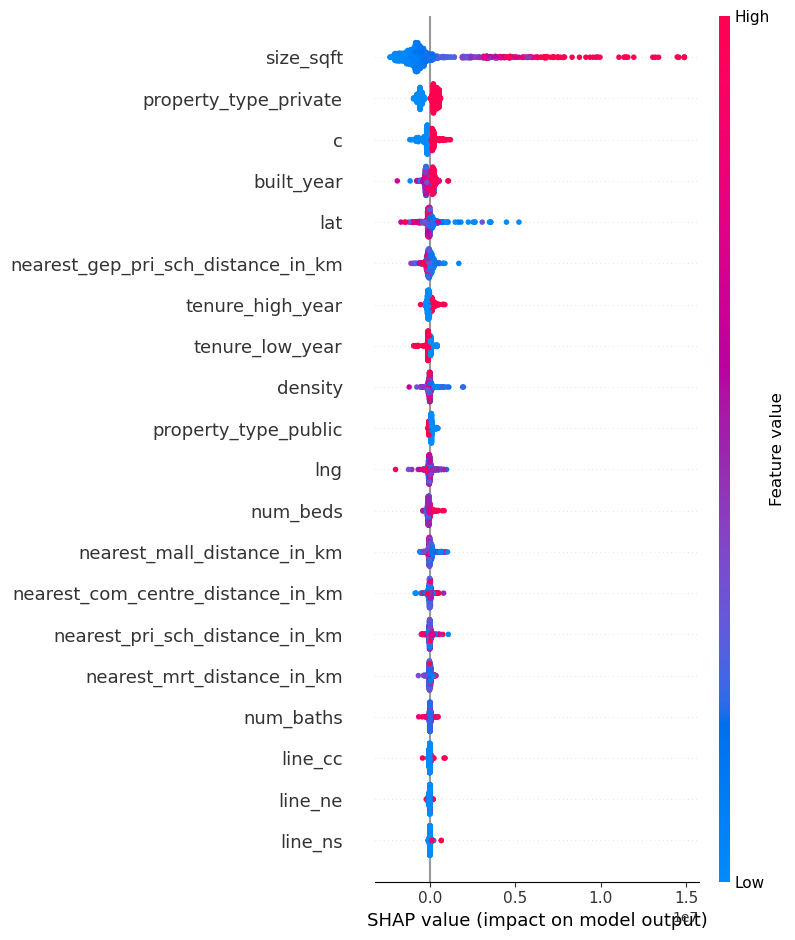

In [108]:
# use a random sample of dataset due to resource limitations
shap_df_train_sample = shap_df_train.copy()
shap_df_train_sample = shap_df_train_sample[:1000]
X_train_sample =  X_train[:1000]

# cannot fit pipeline model 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_df_train_sample)

shap.summary_plot(shap_values, shap_df_train_sample)

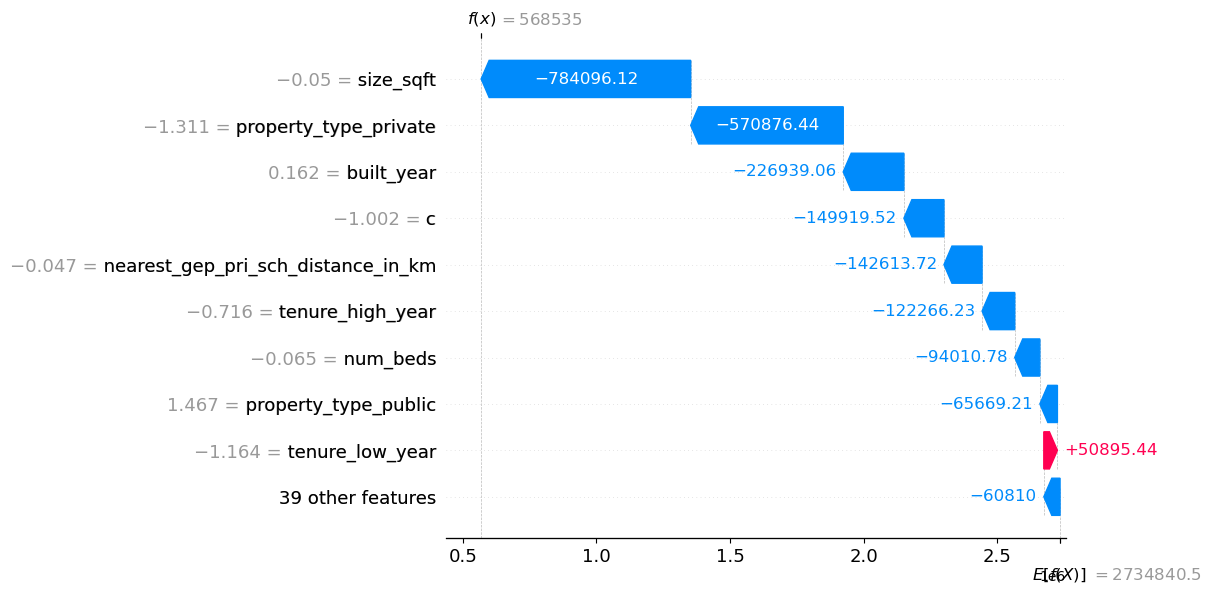

In [109]:
# visualize the first prediction's explanation
shap.plots.waterfall(explainer(shap_df_train_sample)[0])

In [111]:
shap_interactn_values = shap.TreeExplainer(model).shap_interaction_values(shap_df_train_sample)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [112]:
shap_interactn_values.shape

(1000, 48, 48)

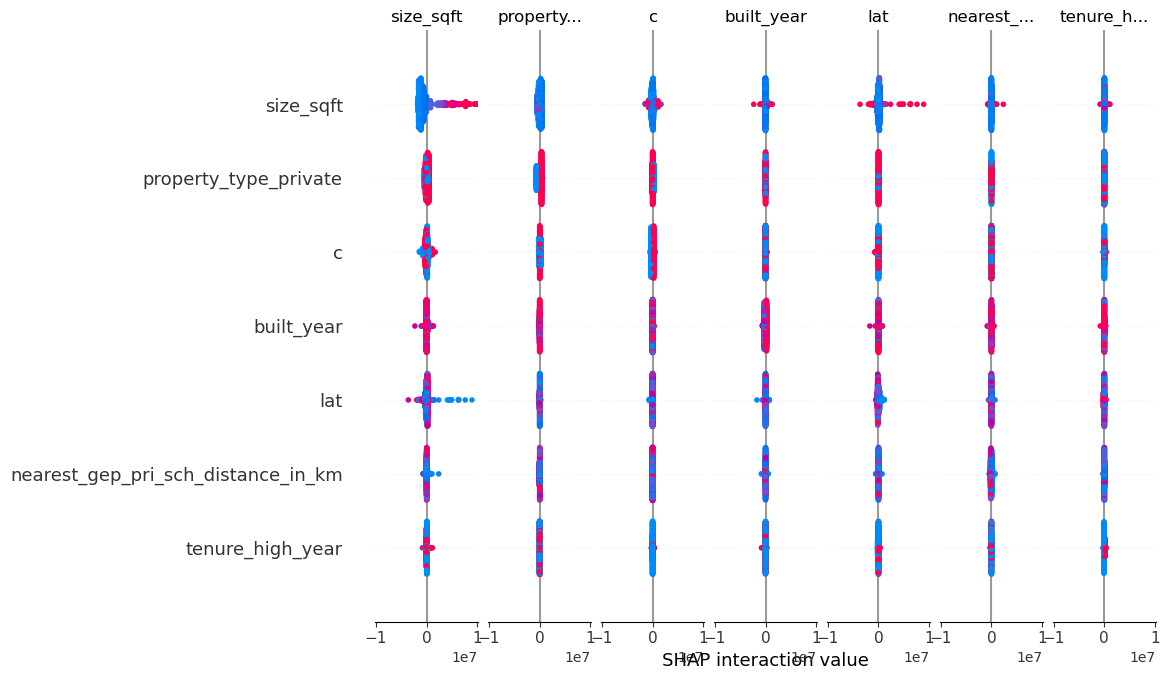

In [113]:
shap.summary_plot(shap_interactn_values, shap_df_train_sample)

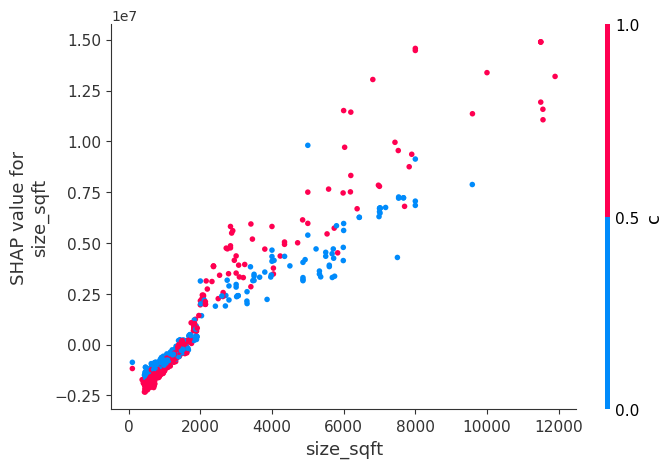

In [116]:
shap.dependence_plot("size_sqft", shap_values, X_train_sample)

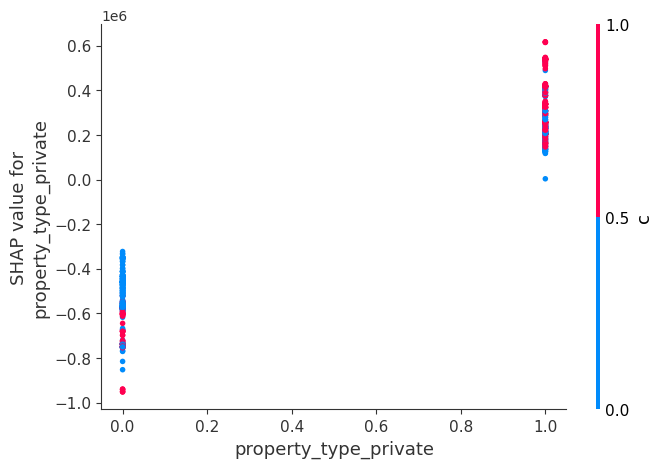

In [128]:
shap.dependence_plot("property_type_private", shap_values, X_train_sample)

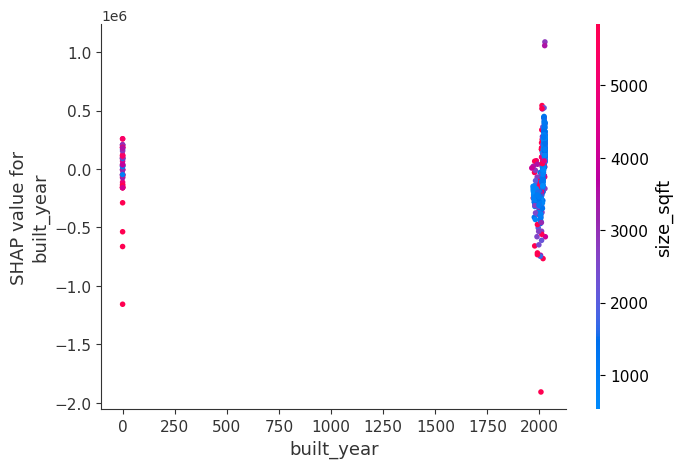

In [130]:
shap.dependence_plot("built_year", shap_values, X_train_sample)